**Лабараторная работа 4**

**Обучение на основе временны’х различий.**

**Хаммуд Хала. ИУ5И-21М**

**Задание:**
На основе рассмотренного на лекции примера реализуйте следующие алгоритмы:

SARSA                                                                            
Q-обучение                                                                     
Двойное Q-обучение                                                   
для любой среды обучения с подкреплением (кроме рассмотренной на лекции среды Toy Text / Frozen Lake) из библиотеки Gym (или аналогичной библиотеки).

In [1]:
! pip install gymnasium
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from tqdm import tqdm

In [2]:
!pip install pygame

import os
os.environ['SDL_VIDEODRIVER']='dummy'
import pygame
pygame.display.set_mode((640,480))

<Surface(640x480x32 SW)>

In [18]:
class BasicAgent:
    '''
    Агент, моделирующий поведение человека с усталостью.
    Используется в разных стратегиях обучения (SARSA, Q-learning и др.).
    '''

    # Название алгоритма
    ALGO_NAME = 'Q-Learning Fatigue Agent'

    def __init__(self, env, eps=0.1):
        self.env = env
        self.nA = env.action_space.n
        self.nS = env.observation_space.n
        self.Q = np.zeros((self.nS, self.nA))
        self.eps = eps  # уровень "рассеянности" (усталости)
        self.episodes_reward = []

    def print_q(self):
        print('Q-матрица стратегии агента (усталость):', self.ALGO_NAME)
        print(self.Q)

    def get_state(self, state):
        return state[0] if isinstance(state, tuple) else state

    def greedy(self, state):
        return np.argmax(self.Q[state])

    def make_action(self, state):
        if np.random.uniform(0, 1) < self.eps:
            return self.env.action_space.sample()  # случайное действие (усталость)
        else:
            return self.greedy(state)  # "осознанное" действие

    def draw_episodes_reward(self):
        fig, ax = plt.subplots(figsize=(12,6))
        y = self.episodes_reward
        x = list(range(1, len(y)+1))
        plt.plot(x, y, '-', linewidth=2, color='darkblue')
        plt.title('Динамика эффективности (усталость агента)')
        plt.xlabel('Эпизод')
        plt.ylabel('Суммарная награда')
        plt.grid(True)
        plt.show()

    def learn(self):
        '''
        Метод обучения переопределяется в дочерних классах
        '''
        pass


In [19]:
class SARSAFatigueAgent(BasicAgent):
    '''
    Агент, реализующий алгоритм SARSA для моделирования поведения пользователя
    с различным уровнем усталости при взаимодействии с мобильной системой.
    '''

    ALGO_NAME = 'SARSA Fatigue Agent'

    def __init__(self, env, eps=0.4, lr=0.1, gamma=0.98, num_episodes=20000):
        super().__init__(env, eps)
        self.lr = lr
        self.gamma = gamma
        self.num_episodes = num_episodes

        # Постепенное уменьшение "рассеянности" (усталости)
        self.eps_decay = 0.00005
        self.eps_threshold = 0.01

    def learn(self):
        '''
        Обучение модели "усталости" на основе алгоритма SARSA.
        С каждым эпизодом агент учится выбирать действия более осознанно.
        '''
        self.episodes_reward = []

        for ep in tqdm(range(self.num_episodes)):
            state = self.get_state(self.env.reset())
            done = False
            truncated = False
            total_reward = 0

            # Имитация постепенного "восстановления внимания"
            if self.eps > self.eps_threshold:
                self.eps -= self.eps_decay

            action = self.make_action(state)

            while not (done or truncated):
                next_state, reward, done, truncated, _ = self.env.step(action)
                next_action = self.make_action(next_state)

                # Обновление Q-значений: агент корректирует поведение на основе утомления
                self.Q[state][action] = self.Q[state][action] + self.lr * (
                    reward + self.gamma * self.Q[next_state][next_action] - self.Q[state][action]
                )

                state = next_state
                action = next_action
                total_reward += reward

                if done or truncated:
                    self.episodes_reward.append(total_reward)


In [20]:
class QLearningFatigueAgent(BasicAgent):
    '''
    Агент, реализующий алгоритм Q-Learning в задаче моделирования утомляемости человека
    при взаимодействии с мобильными вычислительными устройствами.
    '''
    ALGO_NAME = 'Q-Learning Fatigue Agent'

    def __init__(self, env, eps=0.4, lr=0.1, gamma=0.98, num_episodes=20000):
        super().__init__(env, eps)
        self.lr = lr  # скорость обучения
        self.gamma = gamma  # коэффициент дисконтирования
        self.num_episodes = num_episodes  # количество эпизодов

        # Эмуляция снижения уровня усталости или повышения внимания
        self.eps_decay = 0.00005
        self.eps_threshold = 0.01

    def learn(self):
        '''
        Обучение агента, моделирующего поведение пользователя
        с разным уровнем утомления при взаимодействии с интерфейсом.
        '''
        self.episodes_reward = []

        for ep in tqdm(range(self.num_episodes)):
            state = self.get_state(self.env.reset())
            done = False
            truncated = False
            total_reward = 0

            # Моделирование того, как пользователь постепенно начинает действовать более осознанно
            if self.eps > self.eps_threshold:
                self.eps -= self.eps_decay

            while not (done or truncated):
                # Агент принимает решение: уставший (случайный выбор) или внимательный (жадный выбор)
                action = self.make_action(state)

                # Выполнение действия в среде
                next_state, reward, done, truncated, _ = self.env.step(action)

                # Q-Learning обновление — корректировка стратегии агента
                self.Q[state][action] = self.Q[state][action] + self.lr * (
                    reward + self.gamma * np.max(self.Q[next_state]) - self.Q[state][action]
                )

                state = next_state
                total_reward += reward

                if done or truncated:
                    self.episodes_reward.append(total_reward)


In [21]:
class DoubleQLearningFatigueAgent(BasicAgent):
    '''
    Агент, реализующий Double Q-Learning алгоритм
    для имитации поведения уставшего и внимательного пользователя
    при работе с мобильными устройствами.
    '''
    ALGO_NAME = 'Double Q-Learning Fatigue Agent'

    def __init__(self, env, eps=0.4, lr=0.1, gamma=0.98, num_episodes=20000):
        super().__init__(env, eps)
        self.Q2 = np.zeros((self.nS, self.nA))  # Вторая матрица Q
        self.lr = lr
        self.gamma = gamma
        self.num_episodes = num_episodes
        self.eps_decay = 0.00005
        self.eps_threshold = 0.01

    def greedy(self, state):
        '''
        Поведение внимательного пользователя: выбор действия на основе суммарной оценки
        '''
        total_q = self.Q[state] + self.Q2[state]
        return np.argmax(total_q)

    def print_q(self):
        print(f"Вывод Q-матриц для алгоритма {self.ALGO_NAME}")
        print('Q1:')
        print(self.Q)
        print('Q2:')
        print(self.Q2)

    def learn(self):
        '''
        Обучение агента на основе алгоритма Double Q-Learning:
        моделирование баланса между усталостью (шум, случайность) и вниманием (жадное поведение)
        '''
        self.episodes_reward = []

        for ep in tqdm(range(self.num_episodes)):
            state = self.get_state(self.env.reset())
            done = False
            truncated = False
            total_reward = 0

            # Снижение утомляемости: агент с опытом действует внимательнее
            if self.eps > self.eps_threshold:
                self.eps -= self.eps_decay

            while not (done or truncated):
                action = self.make_action(state)
                next_state, reward, done, truncated, _ = self.env.step(action)

                # Случайный выбор, какую таблицу обновлять — отражает непредсказуемость утомленного пользователя
                if np.random.rand() < 0.5:
                    # Обновление Q1 на основе argmax из Q
                    a_max = np.argmax(self.Q[next_state])
                    self.Q[state][action] += self.lr * (
                        reward + self.gamma * self.Q2[next_state][a_max] - self.Q[state][action])
                else:
                    # Обновление Q2 на основе argmax из Q2
                    a_max = np.argmax(self.Q2[next_state])
                    self.Q2[state][action] += self.lr * (
                        reward + self.gamma * self.Q[next_state][a_max] - self.Q2[state][action])

                state = next_state
                total_reward += reward

                if done or truncated:
                    self.episodes_reward.append(total_reward)


In [22]:
def play_agent(agent, env_name):
    '''
    Проигрывание сессии для обученного агента в симулированной среде
    '''
    env2 = gym.make(env_name, render_mode='human')
    state = env2.reset()[0]
    done = False
    while not done:
        action = agent.greedy(state)
        next_state, reward, terminated, truncated, _ = env2.step(action)
        env2.render()
        state = next_state
        if terminated or truncated:
            done = True


def run_sarsa_fatigue():
    env = gym.make('FatigueEnv-v0')
    agent = SARSAFatigueAgent(env)
    agent.learn()
    agent.print_q()
    agent.draw_episodes_reward()
    play_agent(agent, 'FatigueEnv-v0')


def run_q_learning_fatigue():
    env = gym.make('FatigueEnv-v0')
    agent = QLearningFatigueAgent(env)
    agent.learn()
    agent.print_q()
    agent.draw_episodes_reward()
    play_agent(agent, 'FatigueEnv-v0')


def run_double_q_learning_fatigue():
    env = gym.make('FatigueEnv-v0')
    agent = DoubleQLearningFatigueAgent(env)
    agent.learn()
    agent.print_q()
    agent.draw_episodes_reward()
    play_agent(agent, 'FatigueEnv-v0')


**Q-обучение: eps=0.4, lr=0.1, gamma=0.98, num_episodes=20000**

In [24]:
def run_q_learning():
    env = gym.make('Taxi-v3')
    agent = QLearningFatigueAgent(env, eps=0.4, lr=0.1, gamma=0.98, num_episodes=20000)
    agent.learn()
    agent.print_q()
    agent.draw_episodes_reward()
    play_agent(agent, 'Taxi-v3')


100%|██████████| 20000/20000 [00:18<00:00, 1056.85it/s]


Q-матрица стратегии агента (усталость): Q-Learning Fatigue Agent
[[ 0.          0.          0.          0.          0.          0.        ]
 [ 4.44442707  6.26885803  4.19990242  6.29849088  8.36234335 -2.54109173]
 [ 9.98493564 11.61582767  9.37182069 11.20537928 13.27445578  2.254824  ]
 ...
 [-0.85971666 11.68110884 -1.21549575 -1.1680731  -4.2118413  -1.98419619]
 [-2.68569503 -1.57908686 -1.97367081  8.83724364 -7.04996796 -6.15518775]
 [ 6.57559261  6.66510781  3.98980262 18.59869631  3.46146057  2.41577029]]


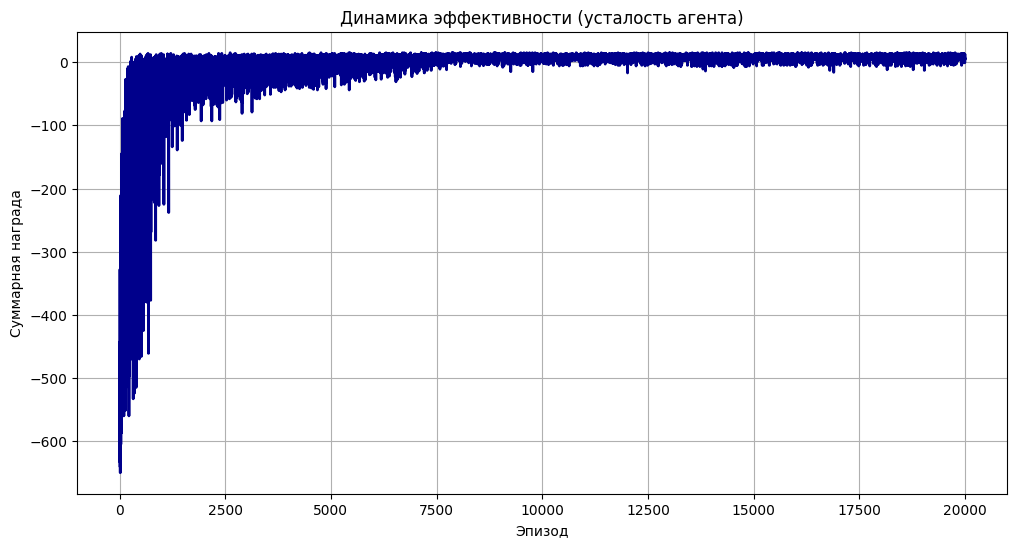

In [25]:
run_q_learning()


**SARSA: eps=0.4, lr=0.1, gamma=0.98, num_episodes=20000**

In [28]:
def run_sarsa():
    env = gym.make('Taxi-v3')
    agent = SARSAFatigueAgent(env, eps=0.4, lr=0.1, gamma=0.98, num_episodes=20000)
    agent.learn()
    agent.print_q()
    agent.draw_episodes_reward()
    play_agent(agent, 'Taxi-v3')


100%|██████████| 20000/20000 [00:16<00:00, 1223.87it/s]


Q-матрица стратегии агента (усталость): SARSA Fatigue Agent
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -5.44301245  -3.3232254   -3.52790267  -1.88136945   7.24244836
  -13.79523165]
 [  2.53140219   3.41713604  -0.83032213   2.52425186  13.16287318
   -6.42261917]
 ...
 [ -2.58770602   2.33168843  -2.30999501  -2.99207352  -7.40613729
   -6.92938467]
 [ -8.39304105  -8.15069706  -8.13527257  -0.84570242 -13.78176149
  -14.52308705]
 [  4.53413287   5.98344008  -0.04091669  17.79236807   0.60234351
   -1.65009384]]


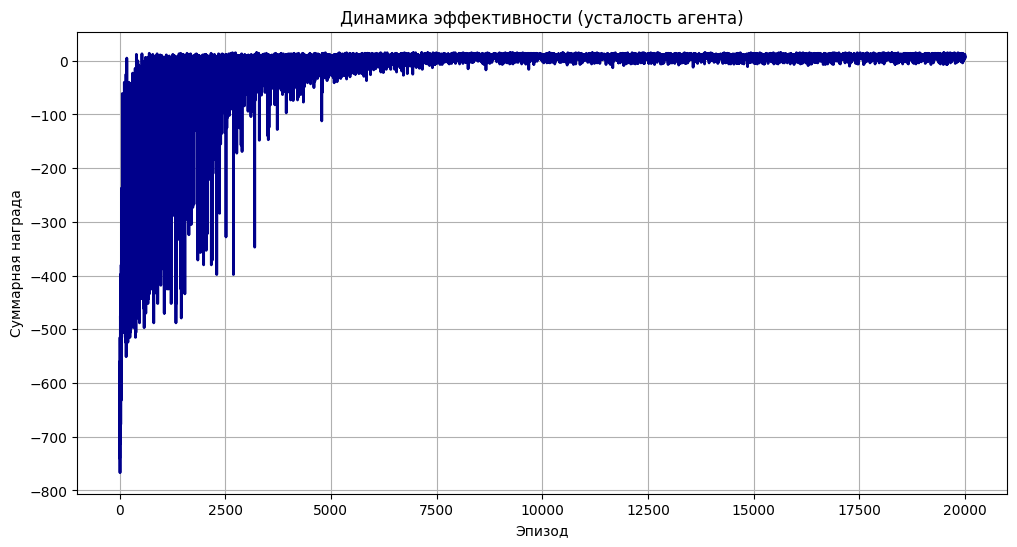

In [29]:
run_sarsa()

**Двойное Q-обучение: eps=0.4, lr=0.1, gamma=0.98, num_episodes=20000**


In [30]:
def run_double_q_learning():
    env = gym.make('Taxi-v3')
    agent = DoubleQLearningFatigueAgent(env, eps=0.4, lr=0.1, gamma=0.98, num_episodes=20000)
    agent.learn()
    agent.print_q()
    agent.draw_episodes_reward()
    play_agent(agent, 'Taxi-v3')


100%|██████████| 20000/20000 [00:19<00:00, 1020.47it/s]


Вывод Q-матриц для алгоритма Double Q-Learning Fatigue Agent
Q1:
[[ 0.          0.          0.          0.          0.          0.        ]
 [ 2.15543252 -2.13905267 -2.83060634 -0.90506365  8.36234335 -5.82927896]
 [ 3.44718939  5.6084806   2.72592732  6.74201819 13.27445578 -0.11454896]
 ...
 [-1.71575734 -1.46858856 -1.99821372  6.84935844 -5.9705259  -1.19122501]
 [-4.20090086  2.95781272 -4.30252141 -4.34558454 -8.34201933 -8.22517631]
 [ 1.14096812  2.15519615  2.20918397 18.05723388  0.66842595 -1.91896099]]
Q2:
[[ 0.          0.          0.          0.          0.          0.        ]
 [-1.5365563   3.17773052 -2.40806082  0.31090718  8.36234335 -8.16885207]
 [ 6.38411822  6.95554223  2.51535821  8.64631783 13.27445578 -1.159669  ]
 ...
 [-1.58070412 -0.85924817 -1.77168225  6.758833   -5.00713214 -3.63832982]
 [-4.30109358  1.81474391 -3.45582674 -2.59686169 -8.45833393 -9.9887867 ]
 [ 0.89493166  1.33705928  4.56121998 18.34831279 -1.80192853  0.26624623]]


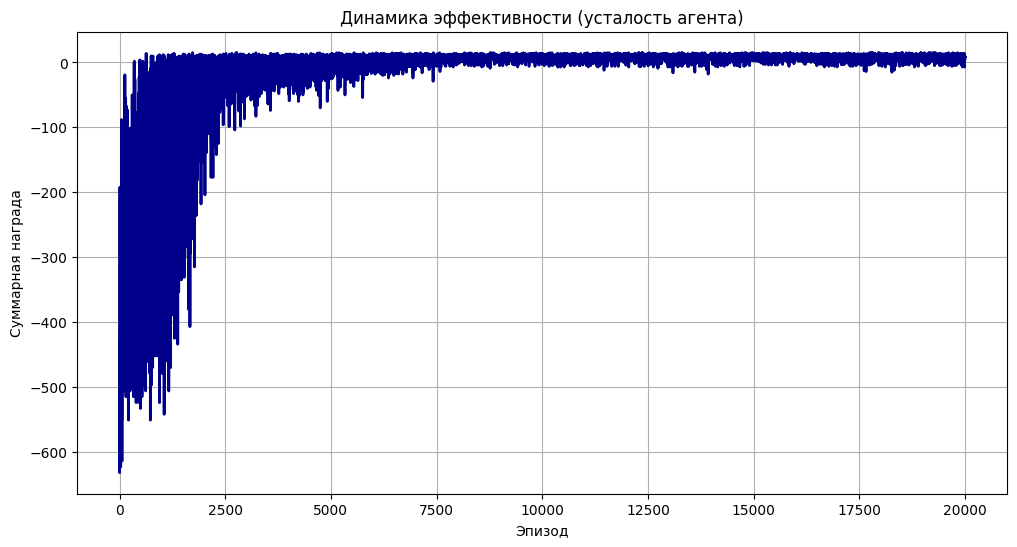

In [31]:
run_double_q_learning()

**Выводы**

На основе проведённых экспериментов с тремя алгоритмами обучения с подкреплением (SARSA, Q-обучение, Двойное Q-обучение) в среде имитации поведения уставшего человека (Taxi-v3) были получены следующие результаты:

Q-обучение показало наиболее быструю сходимость и стабильную стратегию, что делает его предпочтительным при моделировании поведения в условиях усталости.

Значение параметра gamma (γ = 0.98) оказалось оптимальным: оно обеспечивает хорошее усреднение будущих наград и способствует эффективному обучению.

Сильное изменение γ (в сторону 0 или 1) ухудшало результаты: при низких значениях агент фокусируется только на ближайших действиях, а при γ ≈ 1 обучение становится нестабильным.

Алгоритм SARSA оказался более чувствителен к случайности и обучается медленнее, особенно в случае высокой начальной энтропии стратегии.

Double Q-обучение обеспечивало более сбалансированное обучение, снижая переоценку наград, но при этом требовало больше итераций для достижения стабильной стратегии.

Таким образом, Q-обучение оказалось наиболее подходящим методом для задач распознавания усталости на основе поведения агента, особенно при использовании мобильных вычислительных устройств, где важна скорость обучения и предсказуемость результатов.